In [1]:
from hydra import initialize, compose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import mlflow
from collections import defaultdict
from src.utils import load_json
from rdkit import Chem
from src.cheminfo import draw_molecule, draw_reaction
from IPython.display import SVG
from src.similarity import load_similarity_matrix
from src.utils import construct_sparse_adj_mat
from itertools import combinations, chain, product
from scipy.stats import ttest_rel

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="base")

embed_path = Path(filepaths.results) / "embeddings"
mlflow.set_tracking_uri(filepaths.tracking_uri)
production_models = mlflow.search_runs(filter_string="params.'data/split_idx' = '-2'")
production_models.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.epoch,params.training/pos_multiplier,params.model/featurizer,...,params.model/d_h_encoder,params.data/neg_multiple,params.model/encoder_depth,params.model/message_passing,params.data/test_percent,params.model/name,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName
0,84dea227b45b46fb80a5d5559798ff64,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 15:34:47.978000+00:00,2025-02-15 19:34:14.366000+00:00,0.002171,24.0,3,rxn_rc,...,300,3,4,BondMessagePassing,20,rc_agg,spn1560,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL,gifted-kite-152
1,4766fb380a3e4cd0b2735be4f1d5ee15,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 15:20:39.976000+00:00,2025-02-15 19:30:59.851000+00:00,0.011421,24.0,3,rxn_simple,...,300,3,6,BondMessagePassing,20,bom,spn1560,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL,fortunate-doe-560


In [3]:
krs = load_json(Path(filepaths.data) / "sprhea/v3_folded_pt_ns.json")
adj, idx_sample, idx_feature = construct_sparse_adj_mat(Path(filepaths.data) / f"sprhea/v3_folded_pt_ns.csv")
adj = adj.toarray()

Constructing v3_folded_pt_ns sparse adjacency matrix


In [4]:
for _, row in production_models.iterrows():
    print(f"ID: {row['run_id']}, Name: {row['params.model/name']}")

ID: 84dea227b45b46fb80a5d5559798ff64, Name: rc_agg
ID: 4766fb380a3e4cd0b2735be4f1d5ee15, Name: bom


In [5]:
# Load auxiliary similarity matrices

sim_path = Path(filepaths.results) / 'similarity_matrices'
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'

S_rcmcs = load_similarity_matrix(
    sim_path=sim_path,
    dataset=dataset,
    toc=toc,
    sim_metric='rcmcs'
)

S_gsi = load_similarity_matrix(
    sim_path=sim_path,
    dataset=dataset,
    toc=toc,
    sim_metric='gsi'
)

In [6]:
r_hop_range = [i for i in range(4)] # Run this whether constructing or loading embeddings df

Merge reaction embeddings & label reactions w/ r-hop clusters

In [7]:
# tol = 1e-8
# model_embeds = {}
# for run_id in production_models['run_id']:
#     df = pd.read_parquet(embed_path / run_id / "radial_mask_False/r_hop_1" / "reaction_embeddings.parquet")
#     df.drop(columns='reaction_idx', inplace=True)

#     for r in r_hop_range:
#         cg = pd.read_parquet(embed_path / run_id / f"radial_mask_True/r_hop_{r}" / "reaction_embeddings.parquet")
#         cg.rename(columns={"embedding": f"{r}_hop_embedding"}, inplace=True)
#         cg.drop(columns='reaction_idx', inplace=True)
#         df = pd.merge(df, cg, on="rid", how='inner')

#     for r in r_hop_range:
#         r_clusters = []
#         anchor_embeds = []
#         for embed in df[f"{r}_hop_embedding"]:
#             for i, ae in enumerate(anchor_embeds):
#                 if np.allclose(embed, ae):
#                     r_clusters.append(i)
#                     break
#             else:
#                 r_clusters.append(len(anchor_embeds))
#                 anchor_embeds.append(embed)
#         df[f"{r}_hop_cluster"] = r_clusters


#     model_embeds[run_id] = df
    


In [8]:
# df.head()

In [9]:
# Save

# for run_id, df in model_embeds.items():
#     df.to_parquet(embed_path / run_id / "reaction_embeddings_summary.parquet")

In [10]:
# for r in r_hop_range:
#     print(f"r={r}")
#     for id, df in model_embeds.items():
#         n_unique = df[f"{r}_hop_cluster"].nunique()
#         print(f"Model {id} has {n_unique} clusters")

Load embedding summary df

In [11]:
model_embeds = {}
for run_id in production_models['run_id']:
    df = pd.read_parquet(embed_path / run_id / "reaction_embeddings_summary.parquet")
    model_embeds[run_id] = df

r-hop coarse greining analysis

In [12]:
r_hop_to_sims = defaultdict(dict)
for run_id, df in model_embeds.items():
    print(production_models.loc[production_models['run_id'] == run_id, 'params.model/name'].values[0])
    for r in r_hop_range:
        sim_mean_fg_r_hop_cg = []
        for name, group in df.groupby(f"{r}_hop_cluster"):
            
            # Skip singletons
            if len(group) == 1:
                continue

            mean_fg = np.array(list(group["embedding"])).mean(axis=0)
            cg = group[f"{r}_hop_embedding"].iloc[0]
            # sim = np.linalg.norm(mean_fg - cg)
            # sim = np.dot(mean_fg, cg) / (np.linalg.norm(mean_fg) * np.linalg.norm(cg))
            sim = sigmoid(np.dot(mean_fg, cg))
            sim_mean_fg_r_hop_cg.append(sim)
        
        r_hop_to_sims[run_id][r] = sim_mean_fg_r_hop_cg
        print(f"r={r}, mean: {np.mean(sim_mean_fg_r_hop_cg):.3f}, sem: {np.std(sim_mean_fg_r_hop_cg) / np.sqrt(len(sim_mean_fg_r_hop_cg)):.3f}")

rc_agg
r=0, mean: 0.977, sem: 0.003
r=1, mean: 0.976, sem: 0.004
r=2, mean: 0.989, sem: 0.003
r=3, mean: 0.991, sem: 0.003
bom
r=0, mean: 0.931, sem: 0.007
r=1, mean: 0.948, sem: 0.006
r=2, mean: 0.985, sem: 0.003
r=3, mean: 0.985, sem: 0.004


In [13]:
tmp = {}
for run_id, df in model_embeds.items():
    one_to_one_sims = []
    model_name = production_models.loc[production_models['run_id'] == run_id, 'params.model/name'].values[0]
    print(model_name)
    for i, row in df.iterrows():
        row_sims = []
        for r in r_hop_range:
            fg = row["embedding"]
            cg = row[f"{r}_hop_embedding"]
            sim = sigmoid(np.dot(fg, cg))
            row_sims.append(sim)
        one_to_one_sims.append(row_sims)

    one_to_one_sims = pd.DataFrame(data=one_to_one_sims, columns=[f"{model_name}_{r}_sim" for r in r_hop_range])
    tmp[run_id] = one_to_one_sims
one_to_one_sims = pd.concat(tmp.values(), axis=1)
one_to_one_sims.head()

rc_agg
bom


,rc_agg_0_sim,rc_agg_1_sim,rc_agg_2_sim,rc_agg_3_sim,bom_0_sim,bom_1_sim,bom_2_sim,bom_3_sim
0,1.000000,1.000000,1.000000,1.0,1.000000,1.00000,1.000000,1.000000
1,0.980023,0.999984,1.000000,1.0,0.998075,0.91354,0.999769,0.982576
2,1.000000,0.737221,0.066611,1.0,1.000000,1.00000,1.000000,0.999999
3,1.000000,1.000000,1.000000,1.0,0.999938,1.00000,1.000000,1.000000
4,0.999954,1.000000,1.000000,1.0,0.999217,1.00000,1.000000,1.000000


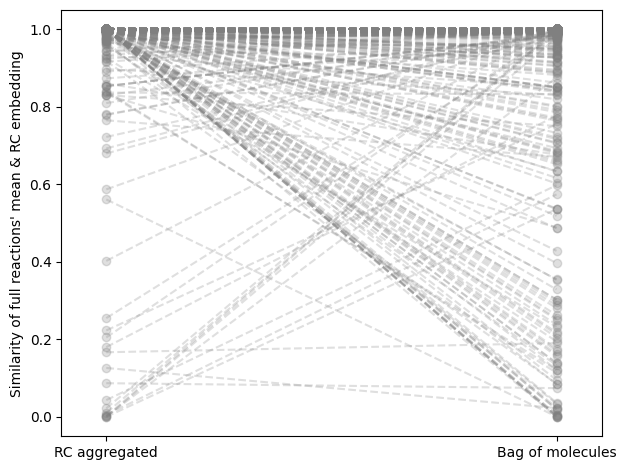

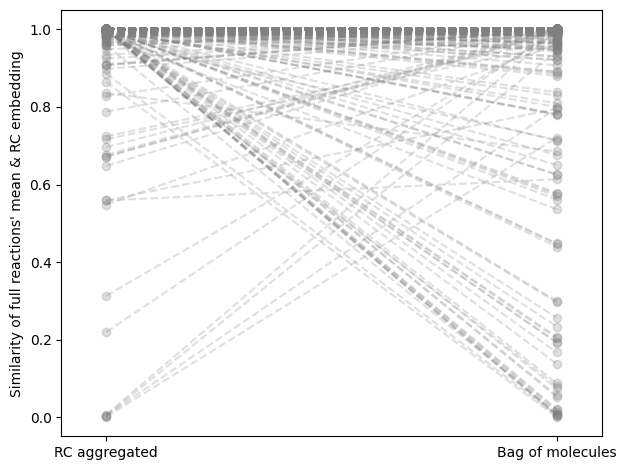

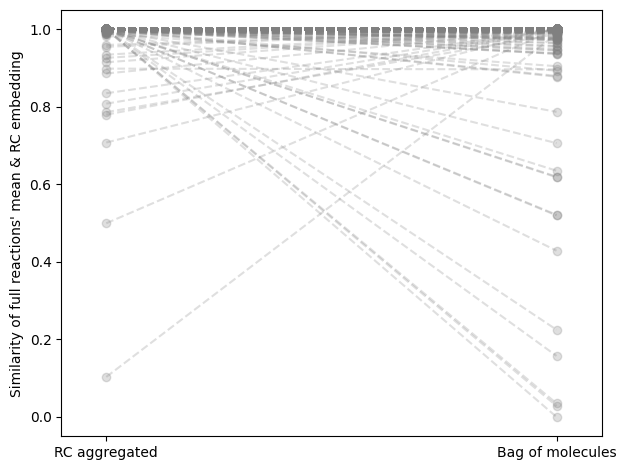

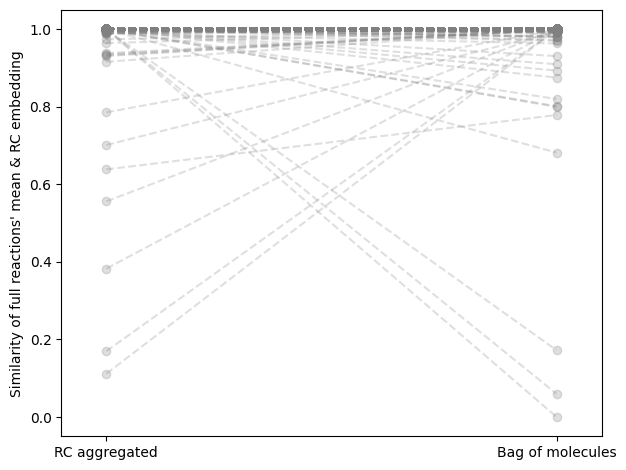

In [16]:
ds = 10 # Downsample for plotting
xlabels = {
    'bom': "Bag of molecules",
    'rc_agg': "RC aggregated"
}
for r in r_hop_range:
    paired_sims = one_to_one_sims.loc[:, [f"{model_name}_{r}_sim" for model_name in production_models['params.model/name']]]
    paired_sims = list(paired_sims.itertuples(index=False, name=None))


    fig, ax = plt.subplots()
    for pair in paired_sims[::ds]:
        ax.plot((0, 1), pair, 'o--', color='grey', alpha=0.25)
        ax.set_ylabel("Similarity of full reactions' mean & RC embedding")
        ax.set_xticks([0, 1], [xlabels[k] for k in production_models['params.model/name']])
        ax.set_xlim(-0.1, 1.1)

    plt.tight_layout()
    plt.savefig(Path(filepaths.figures) / "embedding" / f"paired_comparison_{r}_hop_coarse_grained_mean_fine_grained.svg")
    plt.show()

In [21]:
r = 0
ep = 0
paired_sims = one_to_one_sims.loc[:, [f"{model_name}_{r}_sim" for model_name in production_models['params.model/name']]]
paired_sims = list(paired_sims.itertuples(index=False, name=None))

ct = 0
for pair in paired_sims:
    if pair[0] - pair[1] > ep:
        ct += 1
print(ct)
print("fraction where rca closer than bom", ct / len(paired_sims))

ct = 0
for pair in paired_sims:
    for elt in pair:
        if elt > 0.8:
            ct += 1
print(ct / (len(paired_sims) * 2))

3445
fraction where rca closer than bom 0.6996344435418359
0.8933793663688059


In [22]:
ct = 0
for pair in paired_sims:
    if pair[0] > 0.8:
        ct += 1
print(ct / len(paired_sims))

ct = 0
for pair in paired_sims:
    if pair[1] > 0.8:
        ct += 1
print(ct / len(paired_sims))

0.9398862713241267
0.8468724614134849


In [26]:
rca_sims, bom_sims = zip(*paired_sims)
res = ttest_rel(rca_sims, bom_sims, alternative='greater')
print(res)

TtestResult(statistic=17.219902659449176, pvalue=7.098631757312637e-65, df=4923)


Homology / RCMCS metrics not as good as learned embedding

In [6]:
rc_agg_run_id = '84dea227b45b46fb80a5d5559798ff64'
learned_reaction_embeds = pd.read_parquet(embed_path / rc_agg_run_id / "radial_mask_False/r_hop_1" / "reaction_embeddings.parquet")
learned_protein_embeds = pd.read_parquet(embed_path / rc_agg_run_id / "radial_mask_False/r_hop_1" / "protein_embeddings.parquet")
learned_reaction_embeds.sort_values(by='reaction_idx', inplace=True)
learned_protein_embeds.sort_values(by='protein_idx', inplace=True)
learned_protein_embeds.head()

,protein_idx,pid,embedding
24028,0,P0A6W3,"[0.48014006, -0.1499235, 0.09883036, -0.117462..."
24029,1,P9WMW7,"[0.25044256, -0.32070348, -0.0055622086, -0.24..."
24030,2,O66465,"[0.323564, -0.44214574, 0.015999602, -0.159104..."
12053,3,Q8MJ30,"[0.10457234, -1.1525538, 0.060434222, -0.15925..."
12054,4,P38489,"[-0.17194998, -1.0916122, -0.4695959, -0.21101..."


In [7]:
rxn_embeds = np.vstack(learned_reaction_embeds['embedding'].to_list())
prot_embeds = np.vstack(learned_protein_embeds['embedding'].to_list())
S_rxn_rcgnn = np.matmul(rxn_embeds, rxn_embeds.T)
S_prot_rcgnn = np.matmul(prot_embeds, prot_embeds.T)

In [8]:
rxn_siblings = [] # Catalyzed by same protein
prot_siblings = [] # Catalyze the same reaction

for i, row in enumerate(adj):
    cols = np.argwhere(row > 0).flatten()
    rxn_siblings.append(combinations(cols, 2))

rxn_siblings = list(set(chain(*rxn_siblings)))

for i, row in enumerate(adj.T):
    cols = np.argwhere(row > 0).flatten()
    prot_siblings.append(combinations(cols, 2))

prot_siblings = list(set(chain(*prot_siblings)))

In [ ]:
# percentile_range = np.linspace(0, 100, 1_000)

# S_rcmcs_percentile = np.percentile(S_rcmcs, percentile_range)
# S_gsi_percentile = np.percentile(S_gsi, percentile_range)
# S_rxn_rcgnn_percentile = np.percentile(S_rxn_rcgnn, percentile_range)
# S_prot_rcgnn_percentile = np.percentile(S_prot_rcgnn, percentile_range)

: 

/tmp/ipykernel_35303/1809516751.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


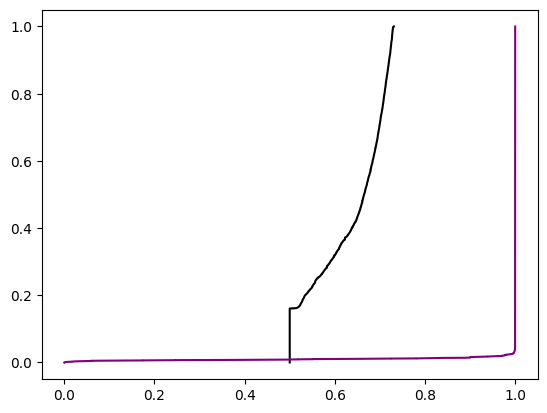

In [9]:
sim_mats = [S_rcmcs, S_rxn_rcgnn]
labels = ["RCMCS", "RC-GNN"]
colors = ["black", "purple"]
i, j = zip(*rxn_siblings)
fig, ax = plt.subplots()
for k, S in enumerate(sim_mats):
    sims = sigmoid(S[i, j])
    xcdf = np.sort(sims)
    ycdf = np.arange(1, len(xcdf) + 1) / len(xcdf)
    ax.plot(xcdf, ycdf, label=labels[k], color=colors[k])
plt.show()

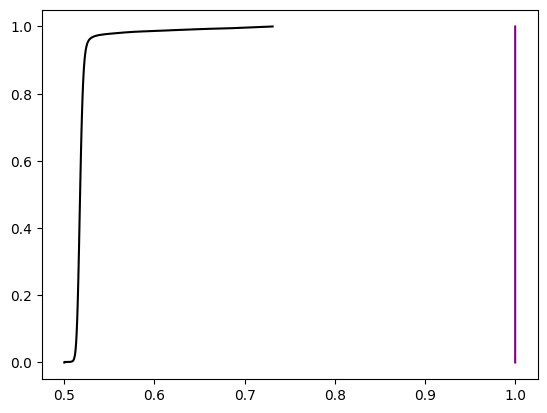

In [10]:
sim_mats = [S_gsi, S_prot_rcgnn]
labels = ["GSI", "RC-GNN"]
colors = ["black", "purple"]
i, j = zip(*prot_siblings)
fig, ax = plt.subplots()
for k, S in enumerate(sim_mats):
    sims = sigmoid(S[i, j])
    xcdf = np.sort(sims)
    ycdf = np.arange(1, len(xcdf) + 1) / len(xcdf)
    ax.plot(xcdf, ycdf, label=labels[k], color=colors[k])
plt.show()